# Plano de Avaliação Experimental - Análise de Resultados

Este notebook documenta a avaliação completa dos modelos de classificação de emoções multi-label em português, comparando um baseline clássico (TF-IDF + Regressão Logística) com um modelo baseado em Transformers (BERTimbau).

### Imports

In [1]:
import os
import re
import json
import io
import warnings
import contextlib
import unicodedata
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import joblib
import shap
import torch
from scipy.special import expit as sigmoid

from captum.attr import IntegratedGradients
from transformers import AutoTokenizer, AutoModelForSequenceClassification


c:\Users\lucas\Julia\multilabel_classification_bert_vs_classic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configurações de diretórios

In [2]:
METRICS_DIR = Path("../outputs/metrics")

BASELINE_FILES = {
    "BERT (Baseline)": METRICS_DIR / "bert_base_cb_loss.json",
    "Clássico (Baseline)": METRICS_DIR / "classic_tfidf.json"
}

# Verifica se os arquivos existem antes de prosseguir
for model_name, path in BASELINE_FILES.items():
    if not path.exists():
        print(f"Alerta: O arquivo de resultado para '{model_name}' não foi encontrado em: {path}")

# Configura o pandas para exibir floats com 4 casas decimais
pd.options.display.float_format = '{:.4f}'.format

## Comparação dos Baselines

**Objetivo:** Avaliar a performance bruta dos modelos "out-of-the-box", utilizando um threshold de classificação fixo de 0.5, sem qualquer otimização ou calibração. Esta análise estabelece nosso ponto de partida e nos ajuda a responder à pergunta: *Qual a vantagem inicial de um modelo profundo em relação a um método clássico neste problema?*

### Carregamento e Processamento dos Dados

In [3]:
baseline_results = []

for model_name, path in BASELINE_FILES.items():
    if not path.exists():
        continue
    
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Extrai as métricas de teste com threshold de 0.5
    metrics = data.get("metrics_test_baseline", {})
    
    # Monta um dicionário com os resultados que nos interessam
    result = {
        "Modelo": model_name,
        "F1-Micro": metrics.get("f1_micro"),
        "F1-Macro": metrics.get("f1_macro"),
        "mAP": metrics.get("map_macro")
    }
    baseline_results.append(result)

# Cria um DataFrame do Pandas para visualização
baseline_df = pd.DataFrame(baseline_results).set_index("Modelo")

print("Resultados dos Baselines (Threshold = 0.5)")
print(baseline_df)

Resultados dos Baselines (Threshold = 0.5)
                     F1-Micro  F1-Macro    mAP
Modelo                                        
BERT (Baseline)        0.5110    0.4114 0.4807
Clássico (Baseline)    0.5028    0.4418 0.4291


### Análise dos Baselines


A tabela acima resume as métricas de desempenho no conjunto de teste para ambos os modelos, antes de qualquer otimização.

* **F1-Micro:** Esta métrica avalia o desempenho geral do agregado de predições.
* **F1-Macro:** Essencial para nosso problema de classes desbalanceadas, esta métrica calcula o F1-Score para cada classe individualmente e tira a média, dando peso igual a todas as classes, independentemente de sua frequência.
* **mAP (Mean Average Precision):** Avalia a qualidade do ranking de probabilidades gerado pelo modelo. Um mAP mais alto indica que o modelo atribui probabilidades mais altas às classes corretas.

**Conclusão Preliminar:**

O modelo **BERT (Baseline)** demonstrou uma performance inferior ao Clássico antes do Retune quando comparado o F1-macro (média simples de F1 por classe). Esse resultado mostra como o modelo clássico é intrinsicamente melhor calibrado do que o modelo baseado em transformers, com as classes raras causando predições de falsos positivos no BERT e piorando o F1-macro. Já o Clássico, que tende a ser mais conservador, gera menos falsos positivos, gerando um F1-macro um pouco melhor. 

Em relação ao F1-micro, o BERT acerta muito mais as classes dominantes já que consegue entender melhor o contexto dos embeddings, diferente do TF-IDF. Nessa métrica, o BERT supera o Clássico, mesmo errando mais as classes raras. Resumidamente, o F1-macro penaliza o BERT por errar classes raras, enquanto o F1-micro recompensa o BERT por acertar muitas classes comuns. Como o intuito dessa pesquisa é avaliar métodos de melhorar a predição de classes raras, o F1-macro foi escolhido para avaliar os modelos.

O mAP por sua vez não usa o tghreshold e avalia o ranking das probabilidades produzidas pelos modelos. O BERT, mesmo mal calibrado, produz probabilidades mais "ordenadas" e coerentes, colocando a classe correta entre as top probabiliodades mesmo que não ultrapasse o threshold. Já o modelo clássico separa pouco as probabilidades e as mantêm pior ordenadas em ranking, levando a um mAP maior no BERT, mesmo com F1-macro pior.

Esta vantagem inicial justifica a exploração mais aprofundada de técnicas de otimização (retuning) para ambos os modelos na próxima fase.

## Análise dos Experimentos de Retune

**Objetivo:** Identificar as estratégias de otimização de threshold e calibração mais eficazes para cada arquitetura de modelo (BERT e Clássico). Responderemos às seguintes perguntas:
1.  Qual foi a combinação de hiperparâmetros que resultou no melhor desempenho geral para cada modelo?
2.  Qual método de calibração (`platt`, `temperature`, `isotonic`) se mostrou mais vantajoso?
3.  Qual o impacto de parâmetros de robustez como `precision_floor`, `topk_hybrid` e `regularize_lambda`?
4.  Como a calibração se comporta nas classes de melhor e pior desempenho?

### Agregação de Todos os Resultados do Grid

In [4]:
# Caminho para a pasta principal onde todos os resultados do grid foram salvos
RETUNES_DIR = Path("../outputs/retunes")

all_results = []

# Regex para extrair os parâmetros do nome da pasta do experimento
PARAM_REGEX = re.compile(
    r"calib=(?P<calibration>\w+)\."
    r"beta=(?P<beta>[\d.]+)\."
    r"pf(?P<precision_floor>[\w.]+)\."
    r"topk=(?P<topk>\d+)\."
    r"cv=(?P<cv>\d+)\."
    r"lam(?P<lambda>[\w.]+)\."
    r"alpha(?P<alpha>[\d.]+)\."
    r"pcap(?P<pcap>[\w.]+)"
)

# Itera sobre as pastas de cada modelo (bert, classic)
for model_dir in RETUNES_DIR.iterdir():
    if not model_dir.is_dir():
        continue
    
    model_family = model_dir.name # ex: 'bert_base_cb_loss'
    
    # Itera sobre cada pasta de experimento dentro da pasta do modelo
    for exp_dir in model_dir.iterdir():
        if not exp_dir.is_dir():
            continue
            
        match = PARAM_REGEX.search(exp_dir.name)
        if not match:
            # print(f"Ignorando pasta com nome fora do padrão: {exp_dir.name}")
            continue
        
        params = match.groupdict()
        
        # Carrega o arquivo de métricas de teste
        metrics_file = exp_dir / f"{model_family}_metrics_test.json"
        if not metrics_file.exists():
            continue
            
        with open(metrics_file, 'r', encoding='utf-8') as f:
            metrics_data = json.load(f).get("metrics_test", {})
        
        # Consolida tudo em um único dicionário
        row = {
            "model_family": "BERT" if "bert" in model_family else "Clássico",
            "model_tag": model_family,
            "experiment_path": str(exp_dir),
            **params,
            "f1_micro": metrics_data.get("f1_micro"),
            "f1_macro": metrics_data.get("f1_macro"),
            "mAP": metrics_data.get("map_macro"),
            "ece": metrics_data.get("ece"),
            "per_class_results": metrics_data.get("per_class_test", {})
        }
        all_results.append(row)

# Cria o DataFrame final com todos os resultados
results_df = pd.DataFrame(all_results)

# Limpeza e conversão de tipos para análise
for col in ['beta', 'precision_floor', 'topk', 'cv', 'lambda', 'alpha', 'pcap']:
    results_df[col] = results_df[col].replace({'None': np.nan, 'nan': np.nan})
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

print(f"Total de {len(results_df)} experimentos de retune carregados.")
print(results_df.head())

results_df.to_csv(RETUNES_DIR / "all_retune_results.csv", index=False)

Total de 24 experimentos de retune carregados.
  model_family          model_tag  \
0         BERT  bert_base_cb_loss   
1         BERT  bert_base_cb_loss   
2         BERT  bert_base_cb_loss   
3         BERT  bert_base_cb_loss   
4         BERT  bert_base_cb_loss   

                                     experiment_path calibration  beta  \
0  ..\outputs\retunes\bert_base_cb_loss\calib=pla...       platt     2   
1  ..\outputs\retunes\bert_base_cb_loss\calib=pla...       platt     2   
2  ..\outputs\retunes\bert_base_cb_loss\calib=pla...       platt     2   
3  ..\outputs\retunes\bert_base_cb_loss\calib=pla...       platt     2   
4  ..\outputs\retunes\bert_base_cb_loss\calib=pla...       platt     2   

   precision_floor  topk  cv  lambda  alpha   pcap  f1_micro  f1_macro    mAP  \
0           0.3000     0   5  0.8500 1.0000 3.0000    0.5579    0.4810 0.4807   
1           0.3000     0   5  0.8500 1.0000    NaN    0.5579    0.4810 0.4807   
2           0.3000     1   5  0.8500 1.000

### Análise BERT

In [5]:
# Filtra apenas os resultados do BERT
bert_df = results_df[results_df['model_family'] == 'BERT'].copy()

# Encontra a melhor combinação de parâmetros para o BERT com base no F1-Macro
best_bert_run = bert_df.loc[bert_df['f1_macro'].idxmax()]

print("🏆 Melhor Execução para o Modelo BERT 🏆")
print("-" * 50)
print(f"Path: {best_bert_run['experiment_path']}")
print(f"F1-Macro: {best_bert_run['f1_macro']:.4f}")
print(f"F1-Micro: {best_bert_run['f1_micro']:.4f}")
print(f"mAP: {best_bert_run['mAP']:.4f}")
print(f"ECE: {best_bert_run['ece']:.4f}")
print("\nParâmetros:")
for param in ['calibration', 'beta', 'precision_floor', 'topk', 'cv', 'lambda', 'alpha', 'pcap']:
    print(f"- {param}: {best_bert_run[param]}")

# Análise do impacto da calibração no BERT
print("\n\n--- Impacto médio da Calibração no BERT (ordenado por F1-Macro) ---")
bert_calib_impact = bert_df.groupby('calibration')[['f1_macro', 'ece']].mean().sort_values('f1_macro', ascending=False)
print(bert_calib_impact)

🏆 Melhor Execução para o Modelo BERT 🏆
--------------------------------------------------
Path: ..\outputs\retunes\bert_base_cb_loss\calib=platt.beta=2.pfNone.topk=0.cv=5.lam0.85.alpha1.0.pcap3.0
F1-Macro: 0.4875
F1-Micro: 0.5513
mAP: 0.4807
ECE: 0.0084

Parâmetros:
- calibration: platt
- beta: 2
- precision_floor: nan
- topk: 0
- cv: 5
- lambda: 0.85
- alpha: 1.0
- pcap: 3.0


--- Impacto médio da Calibração no BERT (ordenado por F1-Macro) ---
             f1_macro    ece
calibration                 
platt          0.4840 0.0084
temperature    0.4831 0.0103


### Análise Clássico

In [6]:
# Filtra apenas os resultados do Clássico
classic_df = results_df[results_df['model_family'] == 'Clássico'].copy()

# Encontra a melhor combinação de parâmetros para o Clássico com base no F1-Macro
best_classic_run = classic_df.loc[classic_df['f1_macro'].idxmax()]

print("🏆 Melhor Execução para o Modelo Clássico 🏆")
print("-" * 50)
print(f"Path: {best_classic_run['experiment_path']}")
print(f"F1-Macro: {best_classic_run['f1_macro']:.4f}")
print(f"F1-Micro: {best_classic_run['f1_micro']:.4f}")
print(f"mAP: {best_classic_run['mAP']:.4f}")
print(f"ECE: {best_classic_run['ece']:.4f}")
print("\nParâmetros:")
for param in ['calibration', 'beta', 'precision_floor', 'topk', 'cv', 'lambda', 'alpha', 'pcap']:
    print(f"- {param}: {best_classic_run[param]}")

# Análise do impacto da calibração no Clássico
print("\n\n--- Impacto médio da Calibração no Modelo Clássico (ordenado por F1-Macro) ---")
classic_calib_impact = classic_df.groupby('calibration')[['f1_macro', 'ece']].mean().sort_values('f1_macro', ascending=False)
print(classic_calib_impact)

🏆 Melhor Execução para o Modelo Clássico 🏆
--------------------------------------------------
Path: ..\outputs\retunes\classic_tfidf\calib=isotonic.beta=2.pfNone.topk=0.cv=5.lam0.85.alpha1.0.pcapNone
F1-Macro: 0.4380
F1-Micro: 0.5060
mAP: 0.4109
ECE: 0.0078

Parâmetros:
- calibration: isotonic
- beta: 2
- precision_floor: nan
- topk: 0
- cv: 5
- lambda: 0.85
- alpha: 1.0
- pcap: nan


--- Impacto médio da Calibração no Modelo Clássico (ordenado por F1-Macro) ---
             f1_macro    ece
calibration                 
isotonic       0.4324 0.0078


### Análise Visual das Curvas de Calibração

Para entender melhor o efeito da calibração, vamos visualizar as curvas geradas para o nosso melhor modelo (BERT). Inspecionaremos as classes onde o modelo teve o **melhor** desempenho e aquelas onde teve o **pior** desempenho, para ver se a calibração se comporta de maneira diferente.

Curvas de Calibração - 3 Classes com Melhor Desempenho (Maior F1)


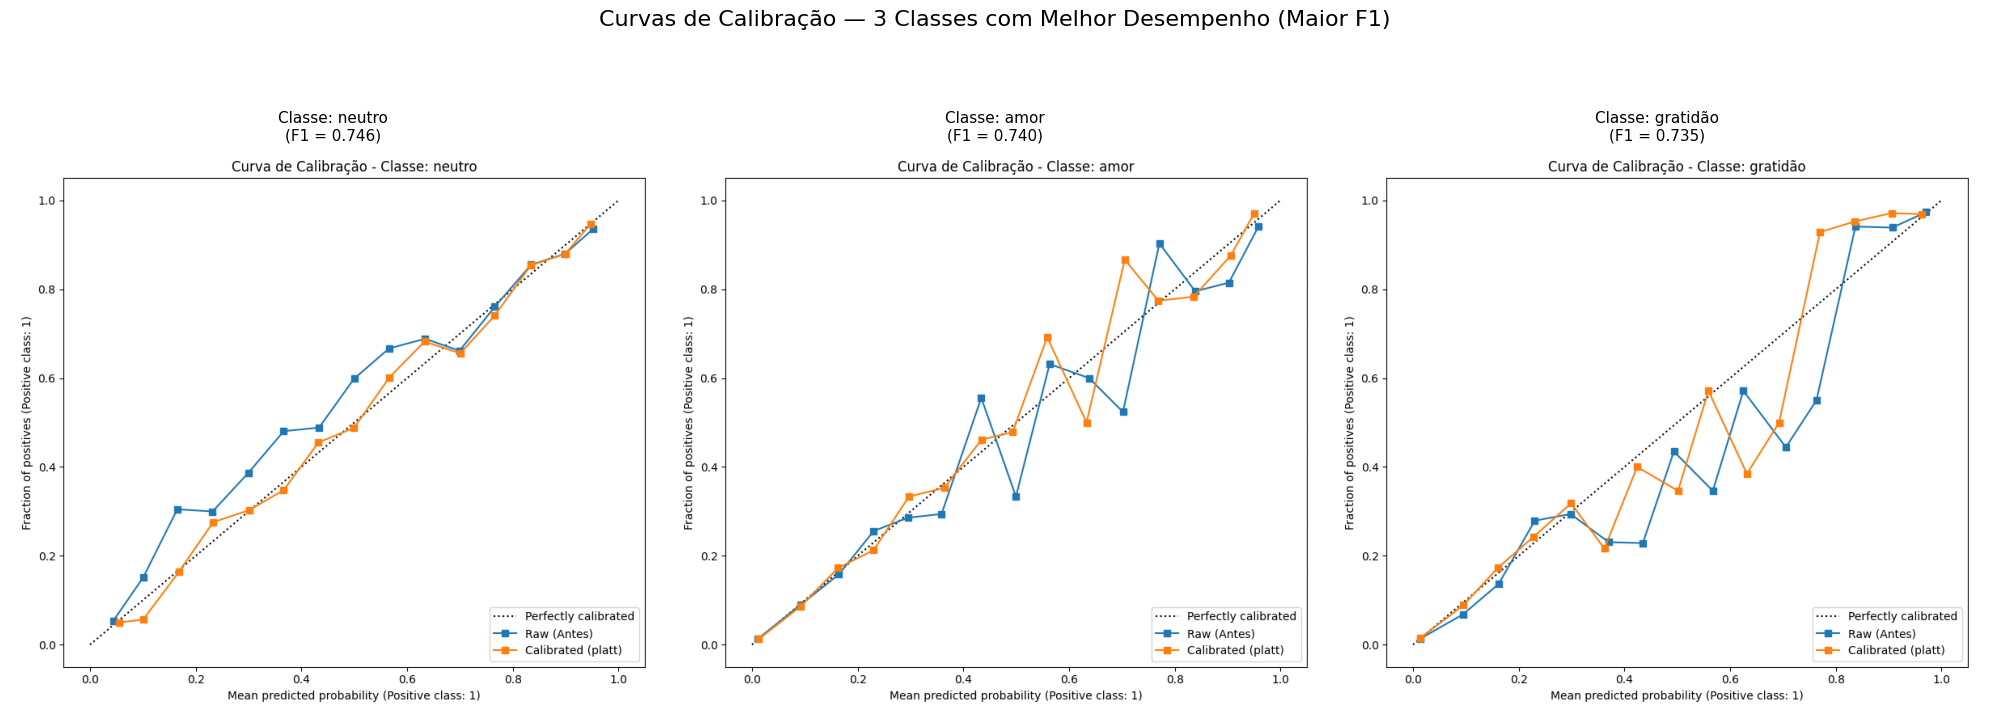

Curvas de Calibração - 3 Classes com Pior Desempenho (Menor F1)


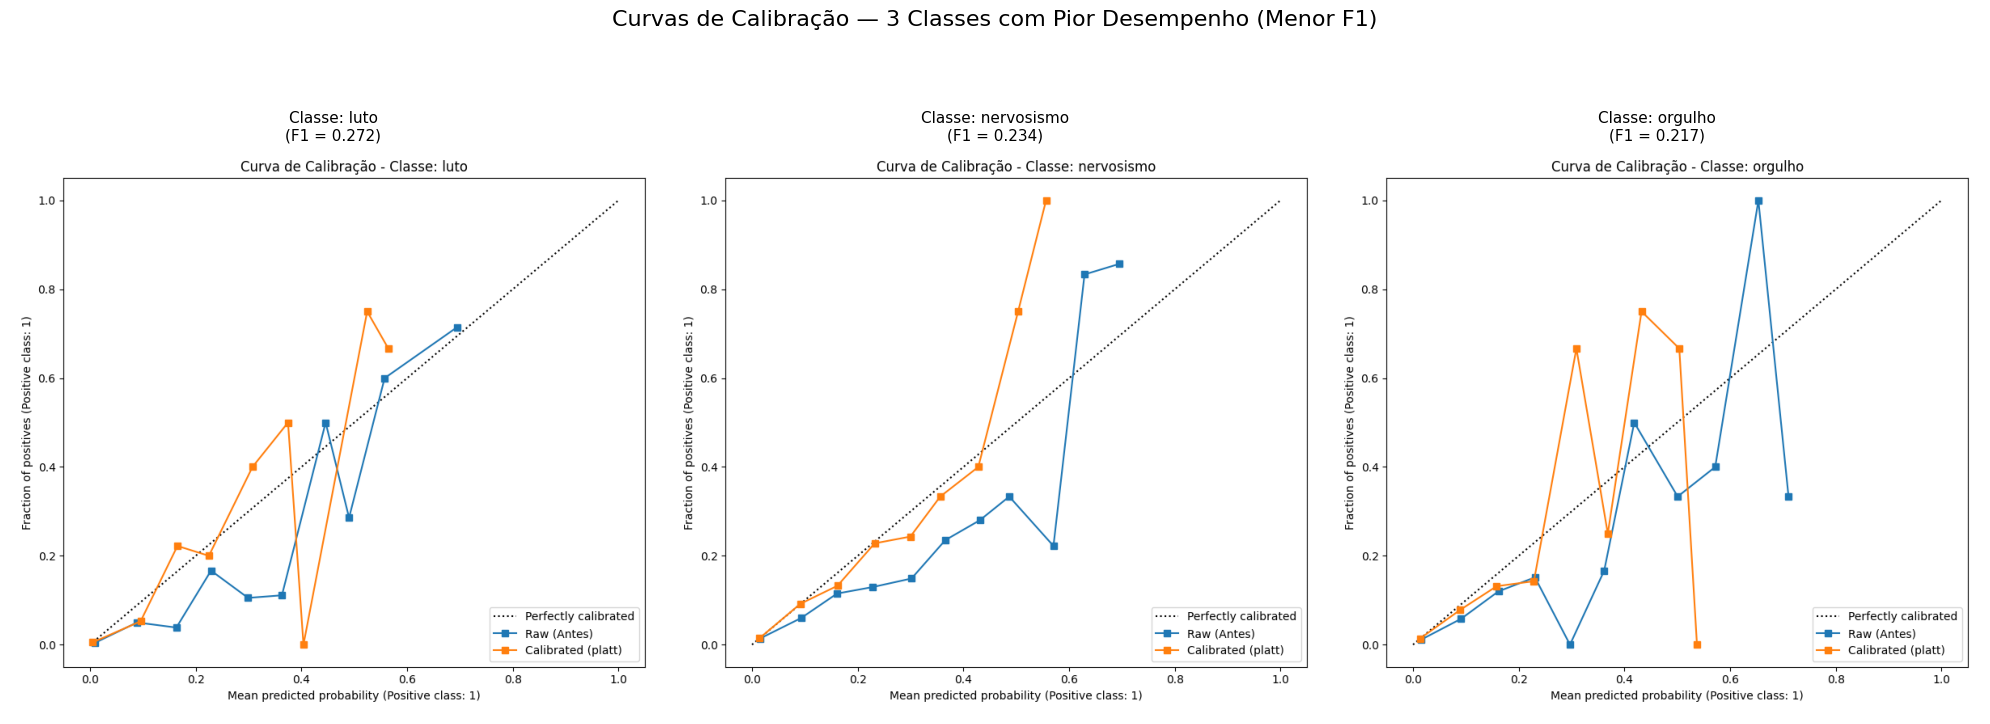

In [7]:
# Usa os resultados do melhor BERT encontrado na Célula 7
best_model_path = Path(best_bert_run['experiment_path'])
per_class_data = best_bert_run['per_class_results']

# Cria um DataFrame com os resultados por classe para facilitar a ordenação
per_class_df = pd.DataFrame.from_dict(per_class_data, orient='index')
per_class_df = per_class_df.sort_values('f1', ascending=False)

# Seleciona as 3 melhores e 3 piores classes
best_3_classes = per_class_df.head(3).index.tolist()
worst_3_classes = per_class_df.tail(3).index.tolist()

# Caminho para a pasta com os gráficos
curves_dir = best_model_path / "calibration_curves"
output_dir = Path("../outputs/interpretability/")
output_dir.mkdir(parents=True, exist_ok=True)

if curves_dir.exists():
    print("Curvas de Calibração - 3 Classes com Melhor Desempenho (Maior F1)")
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    for i, class_name in enumerate(best_3_classes):
        img_path = curves_dir / f"calib_curve_{class_name}.png"
        if img_path.exists():
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Classe: {class_name}\n(F1 = {per_class_df.loc[class_name, 'f1']:.3f})",
                              fontsize=11)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
            axes[i].axis('off')

    # título geral
    fig.suptitle("Curvas de Calibração — 3 Classes com Melhor Desempenho (Maior F1)", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_dir / "curves_melhor_desempenho.png", dpi=200)
    plt.show()

    print("Curvas de Calibração - 3 Classes com Pior Desempenho (Menor F1)")
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    for i, class_name in enumerate(worst_3_classes):
        img_path = curves_dir / f"calib_curve_{class_name}.png"
        if img_path.exists():
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Classe: {class_name}\n(F1 = {per_class_df.loc[class_name, 'f1']:.3f})",
                              fontsize=11)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
            axes[i].axis('off')

    # título geral
    fig.suptitle("Curvas de Calibração — 3 Classes com Pior Desempenho (Menor F1)", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_dir / "curves_pior_desempenho.png", dpi=500)
    plt.show()

else:
    print(f"⚠️ Pasta de curvas de calibração não encontrada em: {curves_dir}")


### Análise dos Resultados da Otimização

In [8]:
final_comparison_data = []

# Adiciona os dados do melhor BERT
final_comparison_data.append({
    "Modelo": "Melhor BERT",
    "F1-Micro": best_bert_run['f1_micro'],
    "F1-Macro": best_bert_run['f1_macro'],
    "mAP": best_bert_run['mAP'],
    "ECE": best_bert_run['ece']
})

# Adiciona os dados do melhor modelo Clássico
final_comparison_data.append({
    "Modelo": "Melhor Clássico",
    "F1-Micro": best_classic_run['f1_micro'],
    "F1-Macro": best_classic_run['f1_macro'],
    "mAP": best_classic_run['mAP'],
    "ECE": best_classic_run['ece']
})

final_comparison_df = pd.DataFrame(final_comparison_data).set_index("Modelo")

print("Tabela Comparativa Final dos Modelos Otimizados")
print(final_comparison_df)

# Também vamos exibir os parâmetros que levaram a esses resultados
print("\nParâmetros do Melhor BERT:")
print(pd.DataFrame(best_bert_run[['calibration', 'beta', 'precision_floor', 'topk', 'cv', 'lambda', 'alpha', 'pcap']]).T)

print("\nParâmetros do Melhor Clássico:")
print(pd.DataFrame(best_classic_run[['calibration', 'beta', 'precision_floor', 'topk', 'cv', 'lambda', 'alpha', 'pcap']]).T)

Tabela Comparativa Final dos Modelos Otimizados
                 F1-Micro  F1-Macro    mAP    ECE
Modelo                                           
Melhor BERT        0.5513    0.4875 0.4807 0.0084
Melhor Clássico    0.5060    0.4380 0.4109 0.0078

Parâmetros do Melhor BERT:
  calibration beta precision_floor topk cv lambda  alpha   pcap
4       platt    2             NaN    0  5 0.8500 1.0000 3.0000

Parâmetros do Melhor Clássico:
   calibration beta precision_floor topk cv lambda  alpha pcap
21    isotonic    2             NaN    0  5 0.8500 1.0000  NaN


### Resultados Finais


A análise do grid de experimentos revela que, para o **modelo BERT**, a calibração **Platt** (`platt`) ofereceu o melhor equilíbrio entre aumento de F1-Macro e redução do erro de calibração (ECE). A combinação vencedora também se beneficiou de um `pcap` 3.0 e de uma regularização `lambda` de 0.85, indicando que tanto a robustez na busca quanto a suavização dos thresholds foram benéficas.

Após o retune, o método corrige esse desequilíbrio entre classes gerando em ganhos expressivos no F1-macro para o BERT. No modelo clássico, porém, o retune não produz melhoras devido às suas probabilidades serem menos discriminativas e menos estáveis, o que limita o efeito do ajuste de thresholds.

As curvas de calibração mostram que o processo foi bem-sucedido em alinhar as probabilidades previstas com as frequências reais, tanto para as classes de alto quanto para as de baixo desempenho. Nas classes de pior desempenho, nota-se que, mesmo após a calibração, a separabilidade do modelo é intrinsecamente menor, o que se reflete em curvas mais distantes da diagonal perfeita. Ainda assim, a classe nervosismo apresenta uma evolução de reliability após a calibração ao aproximar melhor as probabilidades de média ocorrência (por volta de 0.4).

- **Melhor Modelo: BERT:** [calib=platt, beta=2.0, precision_floor: nan, topk0=0, cv=5, lambda=0.85, alpha=1, pcap=3]

### Análise Visual de Desempenho por Classe

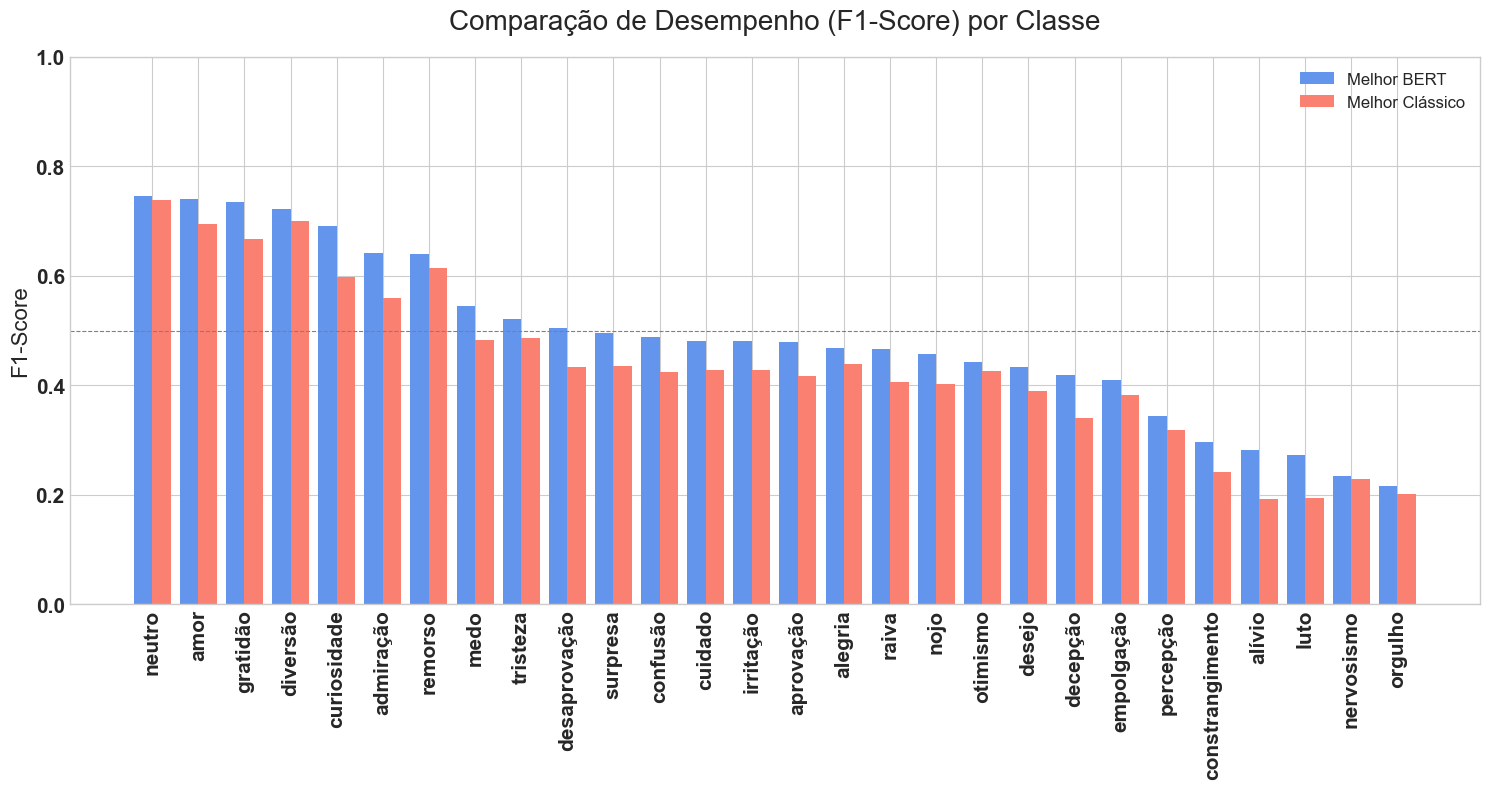

In [9]:
# Extrai os resultados por classe de cada campeão
bert_per_class = best_bert_run['per_class_results']
classic_per_class = best_classic_run['per_class_results']

# Cria DataFrames para facilitar a manipulação
bert_pc_df = pd.DataFrame.from_dict(bert_per_class, orient='index').rename(columns={'f1': 'F1_BERT'})
classic_pc_df = pd.DataFrame.from_dict(classic_per_class, orient='index').rename(columns={'f1': 'F1_Clássico'})

# Junta os dois DataFrames e ordena pelo F1 do BERT para melhor visualização
comparison_pc_df = bert_pc_df.join(classic_pc_df['F1_Clássico']).sort_values('F1_BERT', ascending=False)

# --- Plotagem ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

# Posições das barras
bar_width = 0.4
index = np.arange(len(comparison_pc_df))

# Barras para o BERT
bars1 = ax.bar(index - bar_width/2, comparison_pc_df['F1_BERT'], bar_width, label='Melhor BERT', color='cornflowerblue')

# Barras para o Clássico
bars2 = ax.bar(index + bar_width/2, comparison_pc_df['F1_Clássico'], bar_width, label='Melhor Clássico', color='salmon')

ax.set_ylabel('F1-Score', fontsize=16)
ax.set_title('Comparação de Desempenho (F1-Score) por Classe', fontsize=20, pad=20)
ax.set_xticks(index)
ax.tick_params(axis='y', labelsize=15)
plt.yticks(fontweight='bold')
ax.set_xticklabels(comparison_pc_df.index, rotation=90, fontsize=11)
ax.tick_params(axis='x', labelsize=15)
plt.xticks(fontweight='bold')
ax.legend(fontsize=12)

# Adiciona uma linha horizontal para referência (ex: F1=0.5)
ax.axhline(0.5, color='gray', linestyle='--', linewidth=0.8)

ax.set_ylim(0, 1) # F1-Score vai de 0 a 1
plt.tight_layout()
plt.savefig("../outputs/interpretability/" + "_f1_per_class_bert_vs_classic.png")
plt.show()

### Conclusões

A comparação direta entre os modelos campeões revela que, mesmo após a otimização do baseline clássico, o **modelo BERT mantém uma vantagem substancial**, especialmente na métrica **F1-Macro**. Isso reforça a conclusão de que a capacidade do BERT de entender o contexto e a semântica do texto é crucial para lidar com a natureza desbalanceada e sutil das classes de emoções.

O gráfico de desempenho por classe é particularmente revelador. Podemos observar que:

* **Onde o BERT Domina:** O BERT apresenta uma vantagem significativa em classes que dependem de nuances e contexto, como `luto`, `desejo` e `alívio`. Nestes casos, a simples presença de palavras-chave (que é o forte do TF-IDF) não é suficiente, e a compreensão semântica do BERT se destaca.
* **Onde o Clássico é Competitivo:** O modelo clássico se aproxima do desempenho do BERT em classes com sinais léxicos muito fortes e inequívocos, como `diversão` ou `alegria`, onde a presença de certas palavras é um indicador muito forte.
* **Classes Desafiadoras para Ambos:** Classes como `nervosismo` e `orgulho` mostram-se difíceis para ambas as arquiteturas, indicando que podem ser intrinsecamente mais ambíguas ou sub-representadas no dataset.

## Análise de Erros e Interpretabilidade do Modelo BERT

**Objetivo:** Realizar um mergulho profundo no melhor modelo BERT para entender suas fragilidades e os vieses de seu aprendizado. Esta análise move a nossa avaliação do "o quê" (quais métricas o modelo atingiu) para o "porquê" (por que ele comete certos erros e como ele toma suas decisões). As perguntas que guiaremos são:

1.  Quais são as classes mais problemáticas em termos de falsos positivos e falsos negativos?
2.  Existe um padrão de confusão entre as classes? (ex: o modelo confunde X com Y?)
3.  Qualitativamente, que tipo de texto leva o modelo ao erro?
4.  Quais palavras em uma frase mais influenciam a decisão do modelo para uma determinada classe?

### Identificação das Classes com Mais Erros

In [10]:
# Usaremos o DataFrame por classe do nosso melhor modelo BERT
# A variável 'best_bert_run' foi definida na Fase 2
per_class_bert_df = pd.DataFrame.from_dict(best_bert_run['per_class_results'], orient='index')

# Ordena para ver as classes com mais Falsos Positivos (FP)
top_5_fp = per_class_bert_df.sort_values('fp', ascending=False).head(5)

# Ordena para ver as classes com mais Falsos Negativos (FN)
top_5_fn = per_class_bert_df.sort_values('fn', ascending=False).head(5)

print("Top 5 Classes com Mais Falsos Positivos (FP)")
print(top_5_fp[['fp', 'precision', 'f1']])

print("\nTop 5 Classes com Mais Falsos Negativos (FN)")
print(top_5_fn[['fn', 'recall', 'f1']])

Top 5 Classes com Mais Falsos Positivos (FP)
                fp  precision     f1
neutro        1963     0.6116 0.7463
aprovação     1524     0.3713 0.4782
irritação     1246     0.3646 0.4800
desaprovação  1043     0.3799 0.5043
percepção      847     0.2791 0.3442

Top 5 Classes com Mais Falsos Negativos (FN)
            fn  recall     f1
aprovação  440  0.6716 0.4782
percepção  403  0.4487 0.3442
irritação  303  0.7024 0.4800
decepção   287  0.5729 0.4196
otimismo   261  0.5844 0.4427


### Análise de Confusão Multi-Label

Uma matriz de confusão tradicional não é adequada para problemas multi-label. Em vez disso, construiremos uma **matriz de co-ocorrência de erros**, que nos mostrará, para cada par de classes (X, Y), quantas vezes o modelo previu incorretamente a classe X (Falso Positivo) no mesmo texto em que ele falhou em prever a classe Y (Falso Negativo).

Valores altos nesta matriz indicam que o modelo tende a "trocar" uma classe pela outra.

Gerando Matriz de Confusão Padrão (Verdadeiro vs. Previsto)...


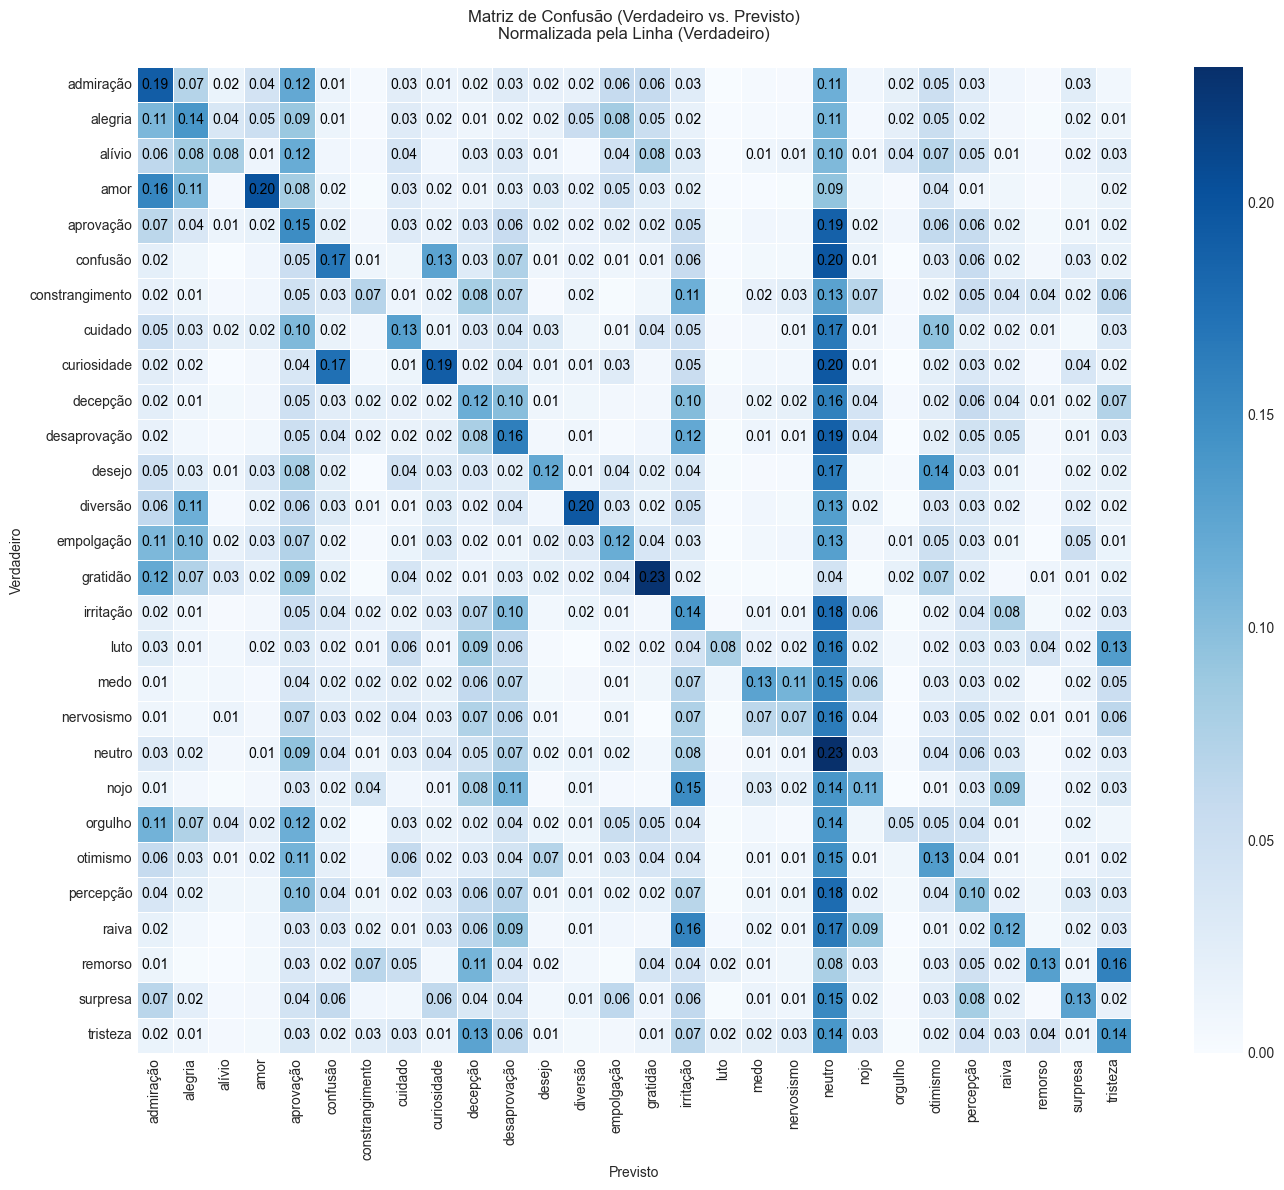

Matriz de confusão padrão salva em: ../outputs/interpretability/_bert_best_retune_confusion_matrix.png
Gerando Heatmap de Co-ocorrência (FN vs. FP)...


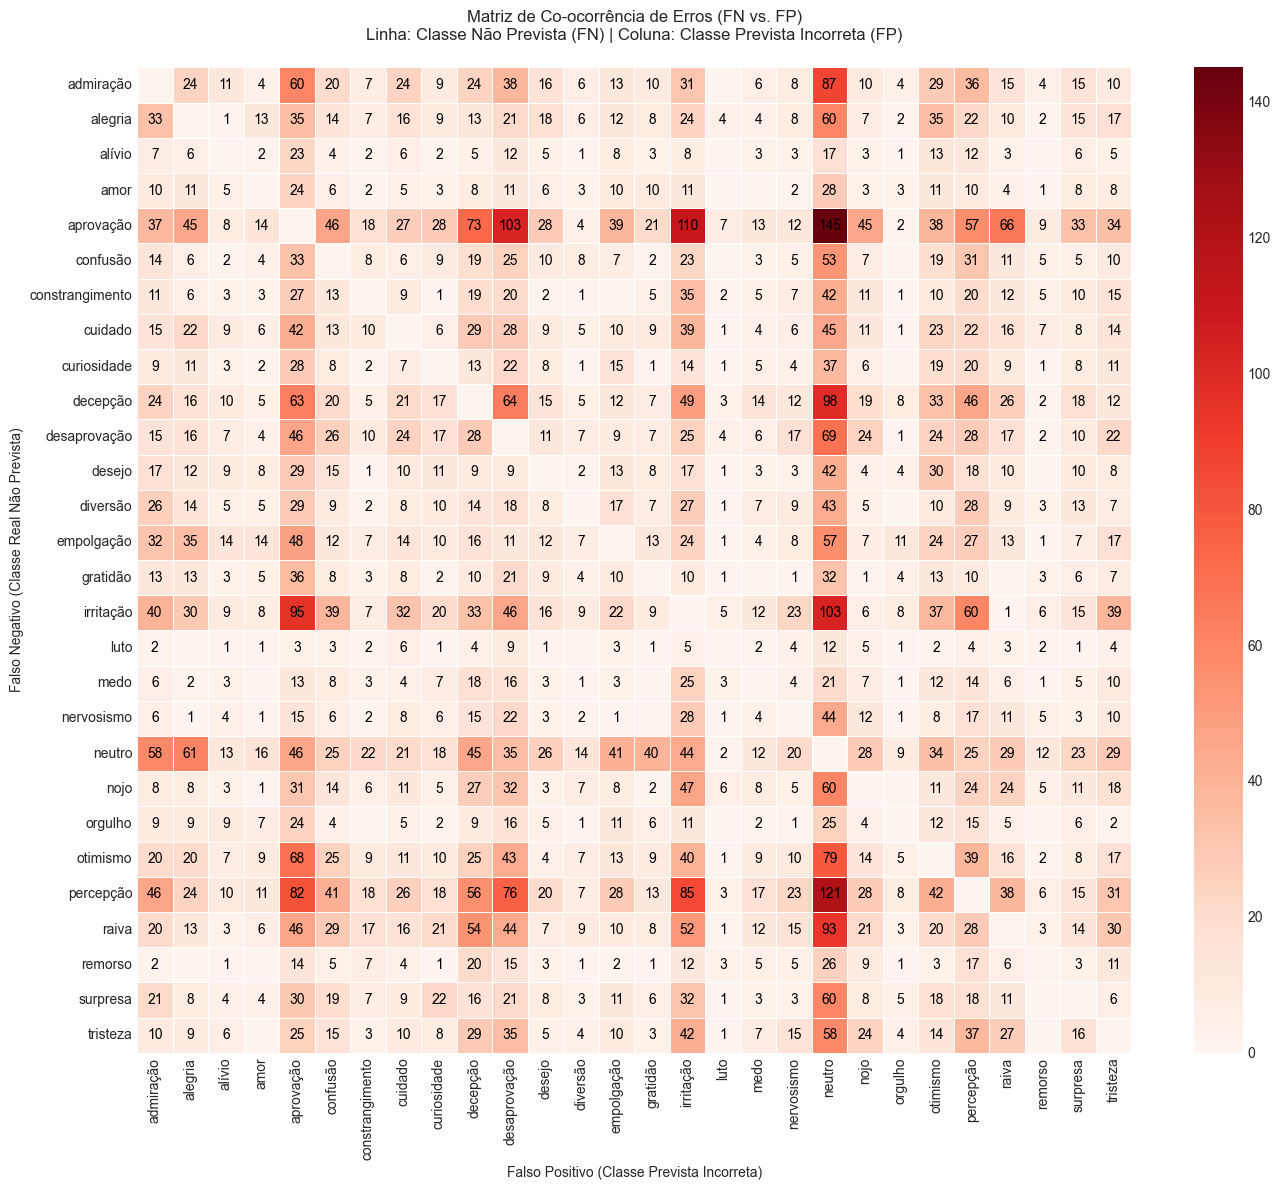

Heatmap de co-ocorrência (FN-FP) salvo em: ../outputs/interpretability/_bert_best_retune_FN_FP_heatmap.png
Gerando Gráfico de Barras Top 10 Pares de Erro (FN-FP)...


C:\Users\lucas\AppData\Local\Temp\ipykernel_5628\1617578823.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_k_errors['Par de Erro'] = top_k_errors['Falso Negativo (Real)'].str.cat(
C:\Users\lucas\AppData\Local\Temp\ipykernel_5628\1617578823.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


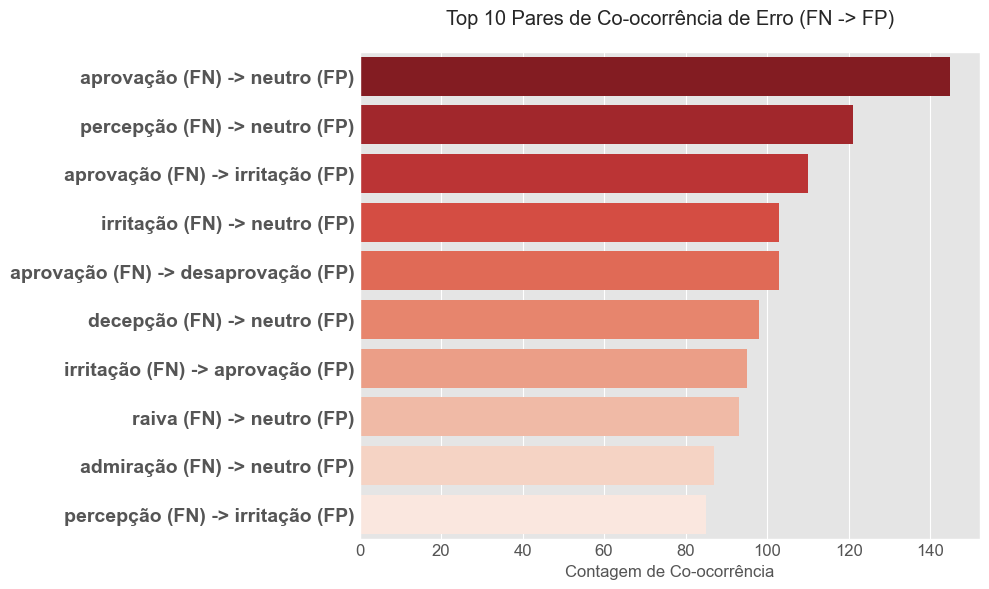

Gráfico de barras de pares de erro salvo em: ../outputs/interpretability/_bert_best_retune_error_pairs_top10.png


In [11]:
# --- Carregar os dados (Seu código) ---
best_bert_path = Path(best_bert_run['experiment_path'])
model_tag = best_bert_run['model_tag']

y_true_test = np.load(METRICS_DIR / f"{model_tag}_test_y_true.npy")
y_prob_test = np.load(METRICS_DIR / f"{model_tag}_test_y_prob.npy")
thresholds = np.load(best_bert_path / f"{model_tag}_thresholds.npy")

y_pred_test = (y_prob_test >= thresholds).astype(int)
class_names = per_class_bert_df.index.tolist()
num_classes = len(class_names)

# ==============================================================================
# GRÁFICO 1: Matriz de Confusão PADRÃO (Verdadeiro vs. Previsto)
# ==============================================================================

print("Gerando Matriz de Confusão Padrão (Verdadeiro vs. Previsto)...")

# 1. Calcular a matriz de confusão multi-label (contagem bruta)
std_conf_matrix = pd.DataFrame(
    np.zeros((num_classes, num_classes)), 
    index=class_names, 
    columns=class_names
)

for i in range(len(y_true_test)):
    true_indices = np.where(y_true_test[i] == 1)[0]
    pred_indices = np.where(y_pred_test[i] == 1)[0]
    
    for t_idx in true_indices:
        for p_idx in pred_indices:
            std_conf_matrix.iloc[t_idx, p_idx] += 1

# 2. Normalizar pela Verdade (por linha)
# (Dividimos pela diagonal, que é a contagem total de cada classe verdadeira)
row_sums = std_conf_matrix.sum(axis=1)

# Adicionar 1e-9 para evitar divisão por zero se uma classe nunca apareceu
std_conf_matrix_norm = std_conf_matrix.div(row_sums + 1e-9, axis=0)

# 3. Plotar o heatmap
plt.figure(figsize=(14, 12))

annot_labels_std = (std_conf_matrix_norm
                    .where(std_conf_matrix_norm > 0.01) # Manter valores > 0.01
                    .map(lambda x: f"{x:.2f}" if pd.notna(x) else "") # Formatar ou string vazia
                   )
sns.heatmap(
    std_conf_matrix_norm,
    annot=annot_labels_std,
    fmt="",
    cmap="Blues",
    linewidths=.5,
    annot_kws={"color": "black", "size": 10, "va": "center", "ha": "center"}
)
plt.title("Matriz de Confusão (Verdadeiro vs. Previsto)\nNormalizada pela Linha (Verdadeiro)", pad=20)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.tight_layout()

# 4. Salvar
conf_matrix_output_filename = "../outputs/interpretability/_bert_best_retune_confusion_matrix.png"
plt.savefig(conf_matrix_output_filename, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print(f"Matriz de confusão padrão salva em: {conf_matrix_output_filename}")

# ==============================================================================
# GRÁFICO 2: Heatmap de Co-ocorrência (FN vs. FP)
# ==============================================================================

# 1. Calcular a Matriz FN-FP
fn_fp_matrix = pd.DataFrame(np.zeros((num_classes, num_classes)), index=class_names, columns=class_names)
for i in range(len(y_true_test)):
    errors = y_pred_test[i] - y_true_test[i]
    fp_indices = np.where(errors == 1)[0]
    fn_indices = np.where(errors == -1)[0]
    
    for fn_idx in fn_indices:
        for fp_idx in fp_indices:
            fn_class = class_names[fn_idx]
            fp_class = class_names[fp_idx]
            fn_fp_matrix.loc[fn_class, fp_class] += 1

# 2. Plotar o Heatmap FN-FP
print("Gerando Heatmap de Co-ocorrência (FN vs. FP)...")

# Filtrar linhas/colunas vazias para uma visualização mais limpa
cm_plot = fn_fp_matrix.loc[(fn_fp_matrix.sum(axis=1) > 0), (fn_fp_matrix.sum(axis=0) > 0)]

if cm_plot.empty:
    print("Matriz de co-ocorrência (FN-FP) está vazia. Pulando heatmap.")
else:
    plt.figure(figsize=(14, 12)) 
    
    annot_labels_fnfp = (cm_plot
                         .where(cm_plot > 0) # Manter valores > 0
                         .map(lambda x: f"{x:.0f}" if pd.notna(x) else "") # Formatar ou string vazia
                        )

    sns.heatmap(
        cm_plot, 
        annot=annot_labels_fnfp, 
        fmt="",              
        cmap="Reds", 
        linewidths=.5,
        annot_kws={"color": "black", "size": 10, "va": "center", "ha": "center"}
    )
    
    plt.title("Matriz de Co-ocorrência de Erros (FN vs. FP)\nLinha: Classe Não Prevista (FN) | Coluna: Classe Prevista Incorreta (FP)", pad=20)
    plt.xlabel("Falso Positivo (Classe Prevista Incorreta)")
    plt.ylabel("Falso Negativo (Classe Real Não Prevista)")
    plt.tight_layout()
    
    heatmap_output_filename = "../outputs/interpretability/_bert_best_retune_FN_FP_heatmap.png"
    plt.savefig(heatmap_output_filename, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close() 
    print(f"Heatmap de co-ocorrência (FN-FP) salvo em: {heatmap_output_filename}")

# ==============================================================================
# GRÁFICO 3: Barplot de Erros (Top 10)
# ==============================================================================

print("Gerando Gráfico de Barras Top 10 Pares de Erro (FN-FP)...")

# 1. Usar a matriz fn_fp_matrix já calculada
error_pairs = fn_fp_matrix.stack().reset_index()
error_pairs.columns = ['Falso Negativo (Real)', 'Falso Positivo (Previsto)', 'Contagem']

# 2. Filtrar e ordenar
top_error_pairs = error_pairs[error_pairs['Contagem'] > 0].sort_values(by='Contagem', ascending=False)

# 3. Selecionar o Top K (MODIFICADO para 10)
K_TOP_PAIRS = 10
top_k_errors = top_error_pairs.head(K_TOP_PAIRS)

# 4. Criar rótulos
if not top_k_errors.empty:
    top_k_errors['Par de Erro'] = top_k_errors['Falso Negativo (Real)'].str.cat(
        top_k_errors['Falso Positivo (Previsto)'], 
        sep=' (FN) -> '
    ) + ' (FP)'
else:
    print("Nenhum par de erro FN-FP encontrado. Pulando gráfico de barras.")

# 5. Plotar
if not top_k_errors.empty:
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Contagem',
        y='Par de Erro',
        data=top_k_errors,
        orient='h',
        palette='Reds_r'
    )
    plt.yticks(fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.title(f"Top {K_TOP_PAIRS} Pares de Co-ocorrência de Erro (FN -> FP)", pad=20)
    plt.xlabel("Contagem de Co-ocorrência")
    plt.ylabel("")
    plt.tight_layout()

    output_filename_bar = "../outputs/interpretability/_bert_best_retune_error_pairs_top10.png"
    plt.savefig(output_filename_bar, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Gráfico de barras de pares de erro salvo em: {output_filename_bar}")

### Análise Qualitativa de Exemplos

In [12]:
# Carregar o texto original do conjunto de teste
test_df = pd.read_csv("../data/processed/test_trunc128.csv")
test_df['y_true'] = list(y_true_test)
test_df['y_pred'] = list(y_pred_test)

def print_error_examples(class_name, error_type, n_examples=3):
    """Função auxiliar para encontrar e exibir exemplos de erros."""
    class_idx = class_names.index(class_name)
    
    if error_type == 'FN':
        # Falso Negativo: true=1, pred=0
        error_mask = (test_df['y_true'].apply(lambda x: x[class_idx] == 1)) & \
                     (test_df['y_pred'].apply(lambda x: x[class_idx] == 0))
        print(f"Exemplos de Falso Negativo para a classe {class_name}")
    elif error_type == 'FP':
        # Falso Positivo: true=0, pred=1
        error_mask = (test_df['y_true'].apply(lambda x: x[class_idx] == 0)) & \
                     (test_df['y_pred'].apply(lambda x: x[class_idx] == 1))
        print(f"\nExemplos de Falso Positivo para a classe {class_name}")
    else:
        return

    examples = test_df[error_mask]
    for i, row in examples.head(n_examples).iterrows():
        print(f"--- Exemplo {i+1} ---")
        print(f"Texto: {row['texto']}")
        
        true_labels = [class_names[i] for i, label in enumerate(row['y_true']) if label == 1]
        pred_labels = [class_names[i] for i, label in enumerate(row['y_pred']) if label == 1]
        
        print(f"Labels Verdadeiras: {true_labels}")
        print(f"Labels Previstas: {pred_labels}\n")

# Analisar a classe com mais Falsos Negativos
worst_fn_class = top_5_fn.index[0]
print_error_examples(worst_fn_class, 'FN')

# Analisar a classe com mais Falsos Positivos
worst_fp_class = top_5_fp.index[0]
print_error_examples(worst_fp_class, 'FP')

Exemplos de Falso Negativo para a classe aprovação
--- Exemplo 11 ---
Texto: "apaixone-se por pelo menos uma atividade física, uma artística e uma intelectual" – este é um ótimo conselho! obrigado 😊
Labels Verdadeiras: ['admiração', 'aprovação', 'gratidão']
Labels Previstas: ['admiração', 'amor', 'cuidado', 'gratidão']

--- Exemplo 13 ---
Texto: "conspiração e traição não são tecnicamente crimes" -[name]
Labels Verdadeiras: ['aprovação', 'neutro']
Labels Previstas: ['desaprovação', 'neutro']

--- Exemplo 21 ---
Texto: "então.. eu vou voltar para minha aula e sentar no meu lugar como você me disse, se você não se importa.."
Labels Verdadeiras: ['aprovação', 'neutro']
Labels Previstas: ['cuidado', 'irritação', 'neutro', 'raiva']


Exemplos de Falso Positivo para a classe neutro
--- Exemplo 1 ---
Texto: !! melhor garota
Labels Verdadeiras: ['admiração', 'amor']
Labels Previstas: ['admiração', 'neutro']

--- Exemplo 5 ---
Texto: "[nome], temos uma oferta para você!"
Labels Verdadeiras: ['d

### Interpretabilidade com SHAP

A biblioteca `shap` é usada aqui para entender *quais palavras* em um texto específico levaram o modelo a tomar uma decisão. Isso nos dá uma interpretabilidade a nível local.


In [13]:
# arrays 2D (N, C)
Yt = np.array(list(test_df['y_true'].values))
Yp = np.array(list(test_df['y_pred'].values))
C = len(class_names)

# -----------------------------------------------------------
# 1) Matriz de confusões multilabel A→B (verdadeiro A, previsto B, não previsto A)
# -----------------------------------------------------------
def confusion_pairs_matrix(Y_true: np.ndarray, Y_pred: np.ndarray, enforce_notB: bool = True):
    N, C = Y_true.shape
    counts = np.zeros((C, C), dtype=int)
    for a in range(C):
        mask_A = (Y_true[:, a] == 1) & (Y_pred[:, a] == 0)
        if not np.any(mask_A): 
            continue
        # candidatos B (preditos 1)
        Yp_A0 = Y_pred[mask_A]       # (nA, C)
        Yt_A1 = Y_true[mask_A]       # (nA, C)
        for b in range(C):
            if b == a: 
                continue
            m = (Yp_A0[:, b] == 1)
            if enforce_notB:
                m &= (Yt_A1[:, b] == 0)
            counts[a, b] = int(m.sum())
    return counts

pair_counts = confusion_pairs_matrix(Yt, Yp, enforce_notB=True)
pair_df = (
    pd.DataFrame(pair_counts, index=class_names, columns=class_names)
      .stack()
      .rename("count")
      .reset_index()
      .rename(columns={"level_0": "A_true", "level_1": "B_pred"})
)
pair_df = pair_df[pair_df["A_true"] != pair_df["B_pred"]]
pair_df = pair_df.sort_values("count", ascending=False)
display(pair_df.head(15))  # top 15 pares de confusão

,A_true,B_pred,count
131,aprovação,neutro,145
663,percepção,neutro,121
127,aprovação,irritação,110
439,irritação,neutro,103
122,aprovação,desaprovação,103
271,decepção,neutro,98
424,irritação,aprovação,95
691,raiva,neutro,93
19,admiração,neutro,87
659,percepção,irritação,85


In [14]:
def sample_confusion_indices(A: str, B: str, top_k: int = 3, score="margin"):
    a = class_names.index(A); b = class_names.index(B)
    mask = (Yt[:, a] == 1) & (Yp[:, a] == 0) & (Yp[:, b] == 1) & (Yt[:, b] == 0)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return []

    # Ordenação por confiança do erro (opções de score)
    if score == "margin":
        # quanto maior P(B) − P(A), mais “confiante” na confusão
        # se você tiver y_prob_test, use aqui; senão usa soma de logits/heurística
        if "y_prob_test" in globals():
            P = np.array(list(y_prob_test))  # (N, C)
            s = P[idx, b] - P[idx, a]
        else:
            # fallback: número de rótulos previstos (mais rótulos = mais confiante)
            s = Yp[idx].sum(axis=1)
    elif score == "pB":
        P = np.array(list(y_prob_test))
        s = P[idx, b]
    else:
        s = np.zeros(len(idx))
    top = idx[np.argsort(-s)[:top_k]]
    return top.tolist()

def print_confusion_examples(A: str, B: str, top_k=3):
    ex_idx = sample_confusion_indices(A, B, top_k=top_k)
    if not ex_idx:
        print(f"[{A}→{B}] sem exemplos.")
        return
    print(f"\n=== Confusão {A} → {B} | {len(ex_idx)} exemplos (exibindo até {top_k}) ===")
    for i, ix in enumerate(ex_idx, 1):
        row = test_df.iloc[ix]
        true_labels = [class_names[j] for j, y in enumerate(row['y_true']) if y == 1]
        pred_labels = [class_names[j] for j, y in enumerate(row['y_pred']) if y == 1]
        print(f"\n--- Exemplo {i} | idx={ix} ---")
        print("Texto:", row['texto'])
        print("True :", true_labels)
        print("Pred :", pred_labels)

# rode nos pares que mais aparecem
for _, r in pair_df.head(6).iterrows():
    print_confusion_examples(r["A_true"], r["B_pred"], top_k=2)


=== Confusão aprovação → neutro | 2 exemplos (exibindo até 2) ===

--- Exemplo 1 | idx=4437 ---
Texto: olá autismo meu velho amigo
True : ['admiração', 'aprovação', 'gratidão', 'irritação']
Pred : ['neutro']

--- Exemplo 2 | idx=5712 ---
Texto: uma vez que eles provam a comida de gato, eles voltam para o gato inteiro.
True : ['aprovação']
Pred : ['neutro']

=== Confusão percepção → neutro | 2 exemplos (exibindo até 2) ===

--- Exemplo 1 | idx=216 ---
Texto: >tfw ela estava explicando para ele o que uma explosão nuclear faria
True : ['curiosidade', 'percepção']
Pred : ['neutro']

--- Exemplo 2 | idx=4761 ---
Texto: porque [nome] não tem tempo para monitorar o que está acontecendo no quarto de um casal.
True : ['desaprovação', 'percepção']
Pred : ['desaprovação', 'irritação', 'neutro']

=== Confusão aprovação → irritação | 2 exemplos (exibindo até 2) ===

--- Exemplo 1 | idx=5398 ---
Texto: sua opinião não importa o suficiente para me provocar :)
True : ['aprovação', 'desaprovação', 'ne

### Carregar o modelo

In [15]:
# --- Carregue o seu melhor modelo BERT ---
MODEL_PATH = "../outputs/models/bert_base_cb_loss_final" 

class_names_path = METRICS_DIR / f"{best_bert_run['model_tag']}_classes.txt"
classes = [l.strip() for l in class_names_path.read_text(encoding="utf-8").splitlines()]
n_classes = len(classes)
cls2id = {c:i for i,c in enumerate(classes)}

print(f"Carregando modelo de: {MODEL_PATH}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Mover o modelo para a GPU se disponível, para acelerar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Colocar o modelo em modo de avaliação

print("Modelo e Tokenizer carregados com sucesso.")

Carregando modelo de: ../outputs/models/bert_base_cb_loss_final
Modelo e Tokenizer carregados com sucesso.


In [16]:
def predict_proba_texts(xs):
    # normaliza para lista de strings
    if isinstance(xs, (list, tuple, np.ndarray, pd.Series)):
        texts = [str(t) for t in xs]
    else:
        texts = [str(xs)]

    enc = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits.detach().cpu().numpy()  # (N, C)
    probs = sigmoid(logits)
    # assegura shape 2D correto
    probs = np.asarray(probs, dtype=float)
    if probs.ndim == 1:
        probs = probs.reshape(1, -1)
    assert probs.shape[1] == len(class_names), f"Esperava {len(class_names)} saídas, veio {probs.shape}"
    return probs

# 2) Sanity check
_test_shape = predict_proba_texts(["ping"]).shape
print("predict_proba_texts shape:", _test_shape)  # deve imprimir (1, n_classes)

# 3) Recrie o Explainer do zero (não reutilize o anterior!)
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_proba_texts, masker, output_names=class_names)

# 4) Mais um sanity: explique um texto com duas saídas
A, B = "aprovação", "desaprovação"   # troque pelos que você quer
outs = [class_names.index(A), class_names.index(B)]
sv = explainer(["texto de teste aqui"], outputs=outs, max_evals=1000)
print("sv shape:", sv.shape)  # esperado: (1, num_tokens, 2)

predict_proba_texts shape: (1, 28)
sv shape: (1, 6, 2)


In [17]:
def shap_confusion_example(ix: int, A: str, B: str, max_evals=4000):
    txt = str(test_df.loc[ix, 'texto'])
    outs = [cls2id[A], cls2id[B]]
    sv = explainer([txt], outputs=outs, max_evals=max_evals)  # ← agora tem 2 saídas
    print(f"\n[Idx {ix}] Verdadeiro contém '{A}', modelo previu '{B}'\nTexto:\n{txt}\n")
    print(f"SHAP — Classe: {A}")
    shap.plots.text(sv[0, :, 0])
    print(f"SHAP — Classe: {B}")
    shap.plots.text(sv[0, :, 1])


In [18]:
if not pair_df.empty:
    A0, B0 = pair_df.iloc[0][["A_true","B_pred"]]
    cand = sample_confusion_indices(A0, B0, top_k=1)
    if cand:
        shap_confusion_example(cand[0], A0, B0, max_evals=5000)


[Idx 4437] Verdadeiro contém 'aprovação', modelo previu 'neutro'
Texto:
olá autismo meu velho amigo

SHAP — Classe: aprovação


SHAP — Classe: neutro


### Gerar e Plotar os SHAP Values

In [19]:
# 1. Instanciar o Explainer do SHAP
explainer = shap.Explainer(predict_proba_texts, tokenizer)

# 2. Escolher um exemplo de texto e a classe para explicar
example_text = '"eu tenho sido abusivo." isso foi antes mesmo de eu perceber suas características narcisistas.'
target_class = "aprovação"

# Carrega a lista de classes para encontrar o índice da nossa classe alvo
class_names_path = METRICS_DIR / f"{best_bert_run['model_tag']}_classes.txt"
classes = [line.strip() for line in class_names_path.read_text(encoding='utf-8').splitlines()]
target_class_index = classes.index(target_class)

# 3. Gerar os SHAP values para o exemplo
print(f"Gerando SHAP values para a classe '{target_class}'...")
shap_values = explainer([example_text])
print("Cálculo SHAP concluído.")

# 4. Plotar a explicação
#    - [:, target_class_index] -> seleciona os valores de todos os tokens para a classe alvo.
shap.plots.text(shap_values[0, :, target_class_index])

Gerando SHAP values para a classe 'aprovação'...
Cálculo SHAP concluído.


### Explicação em massa

In [20]:
TEXT_COL = "texto"
texts = test_df[TEXT_COL].astype(str).tolist()

EMOJI_RX = r"[\U00010000-\U0010ffff]"  # emojis
WORD_RX  = r"[\wáéíóúâêôãõç]+"         # letras/dígitos c/ acentos

def normalize_token(tok: str):
    t = tok.replace("##","").strip().lower()
    # mantém emoji e palavras; remove lixo puro de pontuação
    m = re.findall(fr"({EMOJI_RX}|{WORD_RX})", t, flags=re.IGNORECASE)
    t = "".join(m).strip()
    return t

In [21]:
# ==== modelo/tokenizer/explainer já criados ====
# tokenizer, model, device, class_names (lista ordenada das 28 classes)

masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_proba_texts, masker, output_names=class_names)

In [22]:
USE_PERM = True  # deixe True p mass-explain

if USE_PERM:
    perm_explainer = shap.explainers.Permutation(predict_proba_texts, shap.maskers.Text(tokenizer))
    _explainer = perm_explainer
else:
    _explainer = explainer 

###classes para analisar, baseado em pol distintas
classes_to_scan = ["alegria","empolgação","raiva","irritação","neutro","aprovação"]

N = len(texts)
np.random.seed(42)
subset_idx = np.random.choice(np.arange(N), size=min(800, N), replace=False).tolist()

results = {}
for lbl in classes_to_scan:
    print(f"Agregando SHAP para classe: {lbl} ...")
    results[lbl] = shap_mass_for_class(
        lbl, sample_idx=subset_idx, batch_size=32, max_evals=600, 
        min_freq=5, top_k=25, fast=USE_PERM)

for lbl in classes_to_scan:
    print(f"\n=== {lbl.upper()} — TOP por importância (|SHAP| médio) ===")
    display(results[lbl]["top_import"])
    print(f"--- {lbl.upper()} — TOP tokens pró-classe (SHAP médio +) ---")
    display(results[lbl]["top_pos"])
    print(f"--- {lbl.upper()} — TOP tokens contra-classe (SHAP médio −) ---")
    display(results[lbl]["top_neg"])

### Integrated Gradients

In [23]:
# INTEGRATED GRADIENTS

model.eval(); device = next(model.parameters()).device

def normalize_token(tok: str):
    t = tok.replace("##","").strip().lower()
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"^[^\wáéíóúâêôãõç]+|[^\wáéíóúãõç]+$", "", t, flags=re.IGNORECASE)
    return t

# forward custom para o Captum (usa embeddings como entrada)
emb_layer = model.get_input_embeddings()

def forward_from_emb(embeds, attn_mask, token_type_ids, target_cidx):
    # emb shape: [B, T, H]
    # Injeta embeddings diretamente no encoder:
    outputs = model(inputs_embeds=embeds, attention_mask=attn_mask, token_type_ids=token_type_ids)
    # retorna o logit da classe alvo
    logits = outputs.logits[:, target_cidx]  # [B]
    return logits

def class_attributions_ig(texts, target_label, max_length=128, steps=8, batch_size=16, min_len=3):
    cidx = class_names.index(target_label)
    ig = IntegratedGradients(lambda e, am, tt: forward_from_emb(e, am, tt, cidx))

    agg_sum = defaultdict(float); agg_abs = defaultdict(float); freq = Counter()

    for start in range(0, len(texts), batch_size):
        batch = texts[start:start+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        # baseline = zeros (embeddings zerados) — simples e rápido
        with torch.no_grad():
            base = torch.zeros_like(emb_layer(enc["input_ids"]))

        # atribuições por token (soma sobre a dimensão do embedding → escalar por token)
        attributions = ig.attribute(
            inputs=emb_layer(enc["input_ids"]),  # [B,T,H]
            baselines=base,
            additional_forward_args=(enc["attention_mask"], enc.get("token_type_ids", torch.zeros_like(enc["input_ids"]))),
            n_steps=steps
        )  # [B,T,H]

        attr_token = attributions.sum(dim=-1).detach().cpu().numpy()  # [B,T]

        tokens_batch = [tokenizer.convert_ids_to_tokens(ids) for ids in enc["input_ids"].detach().cpu().numpy()]
        attn_mask = enc["attention_mask"].detach().cpu().numpy()

        for toks, att, vals in zip(tokens_batch, attn_mask, attr_token):
            for tok, m, v in zip(toks, att, vals):
                if m == 0:  # ignora padding
                    continue
                t = normalize_token(tok)
                if not t or len(t) < min_len:
                    continue
                val = float(v)
                agg_sum[t] += val
                agg_abs[t] += abs(val)
                freq[t] += 1

    df = pd.DataFrame({
        "token": list(freq.keys()),
        "freq":  [freq[t] for t in freq],
        "sum_attr":  [agg_sum[t] for t in freq],
        "sum_abs":   [agg_abs[t] for t in freq],
    })
    if df.empty:
        return {"target": target_label, "top_pos": df, "top_neg": df, "top_import": df, "full": df}

    df["mean_attr"] = df["sum_attr"] / df["freq"]
    df["mean_abs"]  = df["sum_abs"]  / df["freq"]

    # rankings globais
    df_top_import = df.sort_values(["mean_abs","freq"], ascending=[False, False]).head(25).reset_index(drop=True)
    df_top_pos    = df.sort_values(["mean_attr","freq"], ascending=[False, False]).head(25).reset_index(drop=True)
    df_top_neg    = df.sort_values(["mean_attr","freq"], ascending=[True,  False]).head(25).reset_index(drop=True)

    return {"target": target_label, "top_import": df_top_import, "top_pos": df_top_pos, "top_neg": df_top_neg, "full": df.sort_values("mean_abs", ascending=False)}

In [24]:
classes_to_scan = ["alegria","empolgação","raiva","irritação","neutro","aprovação"]

# amostrar para acelerar
np.random.seed(42)
subset_idx = np.random.choice(np.arange(len(texts)), size=min(600, len(texts)), replace=False).tolist()
texts_sub = [texts[i] for i in subset_idx]

ig_results = {}
for lbl in classes_to_scan:
    print("Classe:", lbl)
    ig_results[lbl] = class_attributions_ig(texts_sub, lbl, max_length=128, steps=8, batch_size=16)
    display(ig_results[lbl]["top_import"])
    display(ig_results[lbl]["top_pos"])
    display(ig_results[lbl]["top_neg"])

Classe: alegria


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,favoritos,1,6.0437,6.0437,6.0437,6.0437
1,feliz,17,85.9043,85.9043,5.0532,5.0532
2,diversão,1,4.5668,4.5668,4.5668,4.5668
3,orgulho,1,3.3955,3.3955,3.3955,3.3955
4,divertido,3,10.1376,10.1376,3.3792,3.3792
5,engra,1,3.3567,3.3567,3.3567,3.3567
6,boas,2,5.5642,5.5642,2.7821,2.7821
7,comédia,2,5.2706,5.2706,2.6353,2.6353
8,acal,1,2.4945,2.4945,2.4945,2.4945
9,aman,3,7.2528,7.2528,2.4176,2.4176


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,favoritos,1,6.0437,6.0437,6.0437,6.0437
1,feliz,17,85.9043,85.9043,5.0532,5.0532
2,diversão,1,4.5668,4.5668,4.5668,4.5668
3,orgulho,1,3.3955,3.3955,3.3955,3.3955
4,divertido,3,10.1376,10.1376,3.3792,3.3792
5,engra,1,3.3567,3.3567,3.3567,3.3567
6,boas,2,5.5642,5.5642,2.7821,2.7821
7,comédia,2,5.2706,5.2706,2.6353,2.6353
8,acal,1,2.4945,2.4945,2.4945,2.4945
9,aman,3,7.2528,7.2528,2.4176,2.4176


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,possivelmente,1,-1.1466,1.1466,-1.1466,1.1466
1,aparentemente,1,-0.8740,0.8740,-0.8740,0.8740
2,conhece,2,-1.7113,1.7113,-0.8557,0.8557
3,legislação,1,-0.8219,0.8219,-0.8219,0.8219
4,postura,1,-0.6890,0.6890,-0.6890,0.6890
5,igno,1,-0.6847,0.6847,-0.6847,0.6847
6,gra,1,-0.6700,0.6700,-0.6700,0.6700
7,cérebro,1,-0.6673,0.6673,-0.6673,0.6673
8,ceu,1,-0.6354,0.6354,-0.6354,0.6354
9,cul,3,-1.8539,1.8539,-0.6180,0.6180


Classe: empolgação


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,favoritos,1,4.1726,4.1726,4.1726,4.1726
1,diversão,1,3.9949,3.9949,3.9949,3.9949
2,aman,3,2.6990,10.2649,0.8997,3.4216
3,feliz,17,50.9699,50.9699,2.9982,2.9982
4,orgulho,1,2.7402,2.7402,2.7402,2.7402
5,preocupado,2,4.4343,4.4343,2.2171,2.2171
6,apaixon,1,2.1133,2.1133,2.1133,2.1133
7,divertido,3,5.9882,6.1100,1.9961,2.0367
8,incrível,8,16.0413,16.0413,2.0052,2.0052
9,engra,1,2.0046,2.0046,2.0046,2.0046


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,favoritos,1,4.1726,4.1726,4.1726,4.1726
1,diversão,1,3.9949,3.9949,3.9949,3.9949
2,feliz,17,50.9699,50.9699,2.9982,2.9982
3,orgulho,1,2.7402,2.7402,2.7402,2.7402
4,preocupado,2,4.4343,4.4343,2.2171,2.2171
5,apaixon,1,2.1133,2.1133,2.1133,2.1133
6,incrível,8,16.0413,16.0413,2.0052,2.0052
7,engra,1,2.0046,2.0046,2.0046,2.0046
8,divertido,3,5.9882,6.1100,1.9961,2.0367
9,boas,2,3.7298,3.7298,1.8649,1.8649


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,possivelmente,1,-1.3119,1.3119,-1.3119,1.3119
1,igno,1,-1.0194,1.0194,-1.0194,1.0194
2,cul,3,-2.9662,2.9662,-0.9887,0.9887
3,pobres,1,-0.9528,0.9528,-0.9528,0.9528
4,descul,9,-7.6544,7.8170,-0.8505,0.8686
5,postura,1,-0.8353,0.8353,-0.8353,0.8353
6,machu,4,-3.2189,3.2189,-0.8047,0.8047
7,aparentemente,1,-0.7759,0.7759,-0.7759,0.7759
8,servir,1,-0.7455,0.7455,-0.7455,0.7455
9,vido,1,-0.7365,0.7365,-0.7365,0.7365


Classe: raiva


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,belo,1,-5.4841,5.4841,-5.4841,5.4841
1,obrigada,1,-5.2963,5.2963,-5.2963,5.2963
2,matou,1,3.1680,3.1680,3.1680,3.1680
3,selvagem,1,2.9699,2.9699,2.9699,2.9699
4,pior,5,14.4338,14.4338,2.8868,2.8868
5,faria,1,-2.5985,2.5985,-2.5985,2.5985
6,agress,1,2.2952,2.2952,2.2952,2.2952
7,abus,1,2.2248,2.2248,2.2248,2.2248
8,diversão,1,2.1813,2.1813,2.1813,2.1813
9,boas,2,-3.0263,4.2995,-1.5131,2.1497


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,matou,1,3.1680,3.1680,3.1680,3.1680
1,selvagem,1,2.9699,2.9699,2.9699,2.9699
2,pior,5,14.4338,14.4338,2.8868,2.8868
3,agress,1,2.2952,2.2952,2.2952,2.2952
4,abus,1,2.2248,2.2248,2.2248,2.2248
5,diversão,1,2.1813,2.1813,2.1813,2.1813
6,perigo,1,2.1285,2.1285,2.1285,2.1285
7,matar,1,1.9153,1.9153,1.9153,1.9153
8,bas,1,1.8661,1.8661,1.8661,1.8661
9,irri,1,1.7132,1.7132,1.7132,1.7132


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,belo,1,-5.4841,5.4841,-5.4841,5.4841
1,obrigada,1,-5.2963,5.2963,-5.2963,5.2963
2,faria,1,-2.5985,2.5985,-2.5985,2.5985
3,apropriado,1,-1.9667,1.9667,-1.9667,1.9667
4,sorte,6,-10.8775,10.8775,-1.8129,1.8129
5,divertido,3,-5.2908,5.2908,-1.7636,1.7636
6,apoiando,1,-1.7249,1.7249,-1.7249,1.7249
7,peru,1,-1.6801,1.6801,-1.6801,1.6801
8,encora,2,-3.3029,3.3029,-1.6514,1.6514
9,corte,1,-1.6209,1.6209,-1.6209,1.6209


Classe: irritação


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,belo,1,-5.9602,5.9602,-5.9602,5.9602
1,obrigada,1,-5.3372,5.3372,-5.3372,5.3372
2,divertido,3,-6.8206,6.8206,-2.2735,2.2735
3,apropriado,1,-2.1930,2.1930,-2.1930,2.1930
4,irri,1,1.8873,1.8873,1.8873,1.8873
5,sorte,6,-10.7358,10.7358,-1.7893,1.7893
6,selvagem,1,1.7420,1.7420,1.7420,1.7420
7,diversão,1,1.7357,1.7357,1.7357,1.7357
8,pior,5,8.6465,8.6465,1.7293,1.7293
9,corte,1,-1.6963,1.6963,-1.6963,1.6963


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,irri,1,1.8873,1.8873,1.8873,1.8873
1,selvagem,1,1.7420,1.7420,1.7420,1.7420
2,diversão,1,1.7357,1.7357,1.7357,1.7357
3,pior,5,8.6465,8.6465,1.7293,1.7293
4,seriamente,1,1.4552,1.4552,1.4552,1.4552
5,tada,1,1.3990,1.3990,1.3990,1.3990
6,agress,1,1.3655,1.3655,1.3655,1.3655
7,trem,1,1.2801,1.2801,1.2801,1.2801
8,abus,1,1.2706,1.2706,1.2706,1.2706
9,agressivo,1,1.2407,1.2407,1.2407,1.2407


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,belo,1,-5.9602,5.9602,-5.9602,5.9602
1,obrigada,1,-5.3372,5.3372,-5.3372,5.3372
2,divertido,3,-6.8206,6.8206,-2.2735,2.2735
3,apropriado,1,-2.1930,2.1930,-2.1930,2.1930
4,sorte,6,-10.7358,10.7358,-1.7893,1.7893
5,corte,1,-1.6963,1.6963,-1.6963,1.6963
6,peru,1,-1.5141,1.5141,-1.5141,1.5141
7,encora,2,-3.0186,3.0186,-1.5093,1.5093
8,prec,1,-1.4485,1.4485,-1.4485,1.4485
9,apoiando,1,-1.3984,1.3984,-1.3984,1.3984


Classe: neutro


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,belo,1,-5.9344,5.9344,-5.9344,5.9344
1,obrigada,1,-5.4217,5.4217,-5.4217,5.4217
2,plenamente,1,-4.5804,4.5804,-4.5804,4.5804
3,favoritos,1,-4.0703,4.0703,-4.0703,4.0703
4,obrigado,22,-86.1958,86.1958,-3.9180,3.9180
5,incrível,8,-25.4314,25.4314,-3.1789,3.1789
6,valeu,1,-2.5600,2.5600,-2.5600,2.5600
7,perigo,1,-2.3892,2.3892,-2.3892,2.3892
8,preocupado,2,-4.7473,4.7473,-2.3736,2.3736
9,feliz,17,-40.1026,40.1026,-2.3590,2.3590


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,tornar,1,1.1953,1.1953,1.1953,1.1953
1,estro,1,0.9420,0.9420,0.9420,0.9420
2,possivelmente,1,0.8677,0.8677,0.8677,0.8677
3,precisava,1,0.6638,0.6638,0.6638,0.6638
4,temos,1,0.6531,0.6531,0.6531,0.6531
5,individual,1,0.6521,0.6521,0.6521,0.6521
6,especial,1,0.6433,0.6433,0.6433,0.6433
7,apoiando,1,0.6291,0.6291,0.6291,0.6291
8,câncer,1,0.6282,0.6282,0.6282,0.6282
9,mudou,1,0.6057,0.6057,0.6057,0.6057


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,belo,1,-5.9344,5.9344,-5.9344,5.9344
1,obrigada,1,-5.4217,5.4217,-5.4217,5.4217
2,plenamente,1,-4.5804,4.5804,-4.5804,4.5804
3,favoritos,1,-4.0703,4.0703,-4.0703,4.0703
4,obrigado,22,-86.1958,86.1958,-3.9180,3.9180
5,incrível,8,-25.4314,25.4314,-3.1789,3.1789
6,valeu,1,-2.5600,2.5600,-2.5600,2.5600
7,perigo,1,-2.3892,2.3892,-2.3892,2.3892
8,preocupado,2,-4.7473,4.7473,-2.3736,2.3736
9,feliz,17,-40.1026,40.1026,-2.3590,2.3590


Classe: aprovação


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,plenamente,1,6.8259,6.8259,6.8259,6.8259
1,apropriado,1,3.7998,3.7998,3.7998,3.7998
2,compree,1,3.4720,3.4720,3.4720,3.4720
3,belo,1,3.3734,3.3734,3.3734,3.3734
4,faria,1,3.1305,3.1305,3.1305,3.1305
5,certo,9,20.7394,20.9755,2.3044,2.3306
6,boas,2,4.5352,4.5352,2.2676,2.2676
7,concord,2,4.4890,4.4890,2.2445,2.2445
8,culpa,1,2.0513,2.0513,2.0513,2.0513
9,seguro,1,1.9612,1.9612,1.9612,1.9612


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,plenamente,1,6.8259,6.8259,6.8259,6.8259
1,apropriado,1,3.7998,3.7998,3.7998,3.7998
2,compree,1,3.4720,3.4720,3.4720,3.4720
3,belo,1,3.3734,3.3734,3.3734,3.3734
4,faria,1,3.1305,3.1305,3.1305,3.1305
5,certo,9,20.7394,20.9755,2.3044,2.3306
6,boas,2,4.5352,4.5352,2.2676,2.2676
7,concord,2,4.4890,4.4890,2.2445,2.2445
8,culpa,1,2.0513,2.0513,2.0513,2.0513
9,seguro,1,1.9612,1.9612,1.9612,1.9612


,token,freq,sum_attr,sum_abs,mean_attr,mean_abs
0,triste,1,-1.1419,1.1419,-1.1419,1.1419
1,renda,1,-1.1221,1.1221,-1.1221,1.1221
2,sentimentos,1,-0.9081,0.9081,-0.9081,0.9081
3,ouviu,1,-0.7550,0.7550,-0.7550,0.7550
4,ário,1,-0.5975,0.5975,-0.5975,0.5975
5,iron,1,-0.5807,0.5807,-0.5807,0.5807
6,distinguir,1,-0.4906,0.4906,-0.4906,0.4906
7,embar,1,-0.4904,0.4904,-0.4904,0.4904
8,fei,2,-0.9553,0.9553,-0.4776,0.4776
9,destru,1,-0.4388,0.4388,-0.4388,0.4388


### SHAP Mass Explainer com Permutação

In [25]:
# SHAP MASS EXPLAINER FOR CLASS, COM PERMUTATION

def shap_mass_for_class(
    target_label: str,
    sample_idx=None,
    batch_size=32,
    max_evals=600,
    min_len=3,
    min_freq=5,       # filtra tokens muito raros
    top_k=30,
    fast=USE_PERM     # usa Permutation por padrão
):
    cidx = class_names.index(target_label)
    outs = [cidx]
    if sample_idx is None:
        sample_idx = list(range(len(texts)))

    agg_sum = defaultdict(float)
    agg_sum_abs = defaultdict(float)
    counts = Counter()

    expl_used = _explainer if fast else explainer

    for start in range(0, len(sample_idx), batch_size):
        idxs = sample_idx[start:start+batch_size]
        batch_texts = [texts[i] for i in idxs]

        # silencia tqdm/prints do SHAP
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            sv = expl_used(
                batch_texts,
                outputs=outs,
                max_evals=max_evals,
                batch_size=batch_size,
                silent=True
            )  # (B, T, 1)

        # agrega
        for bi, _ in enumerate(idxs):
            tokens = sv.data[bi]
            values = sv.values[bi][:, 0]
            for tok, val in zip(tokens, values):
                t = normalize_token(tok)
                if not t or len(t) < min_len:
                    continue
                v = float(val)
                agg_sum[t]     += v
                agg_sum_abs[t] += abs(v)
                counts[t]      += 1

    df = pd.DataFrame({
        "token": list(counts.keys()),
        "freq":  [counts[t] for t in counts],
        "sum_shap":  [agg_sum[t] for t in counts],
        "sum_abs":   [agg_sum_abs[t] for t in counts],
    })
    if df.empty:
        return {"target_label": target_label, "top_import": df, "top_pos": df, "top_neg": df, "full": df}

    df["mean_shap"] = df["sum_shap"] / df["freq"]
    df["mean_abs"]  = df["sum_abs"]  / df["freq"]

    # filtra por frequência mínima (evitand outliers)
    df = df[df["freq"] >= min_freq].copy()
    if df.empty:
        return {"target_label": target_label, "top_import": df, "top_pos": df, "top_neg": df, "full": df}

    df_top_import = df.sort_values(["mean_abs","freq"], ascending=[False, False]).head(top_k).reset_index(drop=True)
    df_top_pos    = df.sort_values(["mean_shap","freq"], ascending=[False, False]).head(top_k).reset_index(drop=True)
    df_top_neg    = df.sort_values(["mean_shap","freq"], ascending=[True, False]).head(top_k).reset_index(drop=True)

    return {
        "target_label": target_label,
        "top_import": df_top_import,
        "top_pos": df_top_pos,
        "top_neg": df_top_neg,
        "full": df.sort_values("mean_abs", ascending=False),
    }

#### SHAP nos pares de classe com maior confusão

In [26]:
def get_confusion_indices(A: str, B: str):
    """Retorna índices onde a classe A é verdadeira mas não prevista,
    e a classe B é prevista mas não verdadeira (A→B)."""
    a = class_names.index(A)
    b = class_names.index(B)
    mask = (Yt[:, a] == 1) & (Yp[:, a] == 0) & (Yp[:, b] == 1) & (Yt[:, b] == 0)
    return np.where(mask)[0].tolist()

In [ ]:
top_pairs = pair_df.sort_values("count", ascending=False).head(5)

results_conf_pairs = {}

for _, row in top_pairs.iterrows():
    A, B = row["A_true"], row["B_pred"]
    idxs = get_confusion_indices(A, B)
    if not idxs:
        print(f"[{A}→{B}] sem exemplos — pulando.")
        continue

    print(f"\n=== {A.upper()} → {B.upper()} ({len(idxs)} casos) ===")

    res = shap_mass_for_class(
        target_label=B,
        sample_idx=idxs,
        batch_size=32,
        max_evals=600,
        min_freq=3,      
        top_k=25,
        fast=USE_PERM
    )
    
    results_conf_pairs[(A,B)] = res

    print(f"\n→ TOKENS que mais aumentam probabilidade de {B.upper()} nos erros {A.upper()}→{B.upper()}")
    display(res["top_pos"].head(15))

    print(f"\n→ TOKENS que mais reduzem probabilidade de {B.upper()} (SHAP negativo)")
    display(res["top_neg"].head(15))


=== APROVAÇÃO → NEUTRO (145 casos) ===


## Export dos resultados de Integrated Gradients e Shap Mass Explain com Permutation para csv

In [ ]:
def _slugify(text: str) -> str:
    # remove acentos e caracteres perigosos pra nome de arquivo
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^a-zA-Z0-9._-]+", "_", text).strip("_")
    return text.lower()

def export_ig_results(
    ig_results: Dict[str, Dict[str, Any]],
    out_dir: str = "outputs/interpretability/ig",
    consolidated_name: str = "ig_tokens_resumo.csv",
    dump_name: str = "ig_results.joblib",
    which_tables: List[str] = ("top_import", "top_pos", "top_neg"),
    encoding: str = "utf-8"
) -> Dict[str, Any]:
    """
    Exporta resultados de Integrated Gradients (ig_results) em três formatos:
      1) CSVs por classe: <classe>_<top_*>.csv
      2) CSV consolidado único: ig_tokens_resumo.csv
      3) Dump completo do objeto: ig_results.joblib

    Parâmetros
    ----------
    ig_results : dict
        Dicionário no formato:
        {
          "classe": {
             "top_import": pd.DataFrame,
             "top_pos": pd.DataFrame,
             "top_neg": pd.DataFrame,
             ... (outros campos opcionais)
          },
          ...
        }
    out_dir : str
        Diretório base de saída.
    consolidated_name : str
        Nome do CSV consolidado.
    dump_name : str
        Nome do arquivo joblib com o objeto completo.
    which_tables : list[str]
        Quais chaves de DataFrame exportar por classe.
    encoding : str
        Encoding dos CSVs.

    Retorna
    -------
    dict com listas de caminhos gerados.
    """
    os.makedirs(out_dir, exist_ok=True)

    per_class_paths = []
    consolidated_rows = []

    # 1) CSVs por classe
    for lbl, res in ig_results.items():
        safe_lbl = _slugify(lbl)
        for name in which_tables:
            df = res.get(name, None)
            if isinstance(df, pd.DataFrame) and not df.empty:
                fpath = os.path.join(out_dir, f"{safe_lbl}_{name}.csv")
                df.to_csv(fpath, index=False, encoding=encoding)
                per_class_paths.append(fpath)

                # acumula para consolidado
                df2 = df.copy()
                df2["classe"] = lbl
                df2["tipo"] = name
                consolidated_rows.append(df2)

    # 2) CSV consolidado
    consolidated_path = None
    if len(consolidated_rows) > 0:
        df_all = pd.concat(consolidated_rows, ignore_index=True)
        consolidated_path = os.path.join(out_dir, consolidated_name)
        df_all.to_csv(consolidated_path, index=False, encoding=encoding)

    # 3) Dump do objeto completo
    dump_path = os.path.join(out_dir, dump_name)
    joblib.dump(ig_results, dump_path)

    # metadados simples
    meta = {
        "classes": list(ig_results.keys()),
        "tables_exported": list(which_tables),
        "n_files_per_class": len(per_class_paths),
        "consolidated": bool(consolidated_path),
    }
    with open(os.path.join(out_dir, "export_meta.json"), "w", encoding=encoding) as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    return {
        "per_class_csvs": per_class_paths,
        "consolidated_csv": consolidated_path,
        "joblib_dump": dump_path,
        "meta_json": os.path.join(out_dir, "export_meta.json"),
    }


In [ ]:
paths = export_ig_results(ig_results, out_dir="../outputs/interpretability/ig")
paths

{'per_class_csvs': ['../outputs/interpretability/ig\\alegria_top_import.csv',
  '../outputs/interpretability/ig\\alegria_top_pos.csv',
  '../outputs/interpretability/ig\\alegria_top_neg.csv',
  '../outputs/interpretability/ig\\empolgacao_top_import.csv',
  '../outputs/interpretability/ig\\empolgacao_top_pos.csv',
  '../outputs/interpretability/ig\\empolgacao_top_neg.csv',
  '../outputs/interpretability/ig\\raiva_top_import.csv',
  '../outputs/interpretability/ig\\raiva_top_pos.csv',
  '../outputs/interpretability/ig\\raiva_top_neg.csv',
  '../outputs/interpretability/ig\\irritacao_top_import.csv',
  '../outputs/interpretability/ig\\irritacao_top_pos.csv',
  '../outputs/interpretability/ig\\irritacao_top_neg.csv',
  '../outputs/interpretability/ig\\neutro_top_import.csv',
  '../outputs/interpretability/ig\\neutro_top_pos.csv',
  '../outputs/interpretability/ig\\neutro_top_neg.csv',
  '../outputs/interpretability/ig\\aprovacao_top_import.csv',
  '../outputs/interpretability/ig\\aprovacao

In [ ]:
def _slugify(text: str) -> str:
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^a-zA-Z0-9._-]+", "_", text).strip("_")
    return text.lower()

def export_confpair_results(
    results_conf_pairs: Dict[Tuple[str, str], Dict[str, Any]],
    out_dir: str = "outputs/interpretability/conf_pairs",
    which_tables: List[str] = ("top_import", "top_pos", "top_neg"),
    consolidated_name: str = "conf_pairs_tokens_resumo.csv",
    dump_name: str = "results_conf_pairs.joblib",
    pair_df: Optional[pd.DataFrame] = None,     # opcional: para salvar um resumo de contagens
    encoding: str = "utf-8"
) -> Dict[str, Any]:
    """
    Exporta resultados por pares confundidos (A->B).
      1) CSVs por par e por tabela: <A>_to_<B>_<top_*>.csv
      2) CSV consolidado único: conf_pairs_tokens_resumo.csv
      3) Dump completo via joblib: results_conf_pairs.joblib
      4) (Opcional) pairs_summary.csv se pair_df for fornecido

    Parâmetros
    ----------
    results_conf_pairs: dict
        {(A,B): {"top_import": DataFrame, "top_pos": DataFrame, "top_neg": DataFrame, ...}, ...}
    out_dir: str
        Diretório base de saída.
    which_tables: list[str]
        Quais chaves de DataFrame exportar por par.
    consolidated_name: str
        Nome do CSV consolidado.
    dump_name: str
        Nome do arquivo joblib.
    pair_df: pd.DataFrame | None
        DataFrame com colunas como ["A_true","B_pred","count", ...] (opcional).
    encoding: str
        Encoding dos CSVs.

    Retorno
    -------
    dict com caminhos gerados.
    """
    os.makedirs(out_dir, exist_ok=True)

    per_pair_paths = []
    consolidated_rows = []

    # 1) CSVs por par
    for (A, B), res in results_conf_pairs.items():
        safe_A = _slugify(A)
        safe_B = _slugify(B)
        for name in which_tables:
            df = res.get(name, None)
            if isinstance(df, pd.DataFrame) and not df.empty:
                fname = f"{safe_A}_to_{safe_B}_{name}.csv"
                fpath = os.path.join(out_dir, fname)
                df.to_csv(fpath, index=False, encoding=encoding)
                per_pair_paths.append(fpath)

                # acumula para consolidado
                df2 = df.copy()
                df2["pair_from"] = A
                df2["pair_to"]   = B
                df2["tipo"]      = name
                consolidated_rows.append(df2)

    # 2) CSV consolidado
    consolidated_path = None
    if consolidated_rows:
        df_all = pd.concat(consolidated_rows, ignore_index=True)
        consolidated_path = os.path.join(out_dir, consolidated_name)
        df_all.to_csv(consolidated_path, index=False, encoding=encoding)

    # 3) Dump do objeto completo
    dump_path = os.path.join(out_dir, dump_name)
    joblib.dump(results_conf_pairs, dump_path)

    # 4) Resumo opcional de pares (contagens/ ranks)
    summary_path = None
    if pair_df is not None and not pair_df.empty:
        summary_path = os.path.join(out_dir, "pairs_summary.csv")
        pair_df.to_csv(summary_path, index=False, encoding=encoding)

    # meta
    meta = {
        "n_pairs": len(results_conf_pairs),
        "pairs": [f"{A}→{B}" for (A,B) in results_conf_pairs.keys()],
        "tables_exported": list(which_tables),
        "n_files_per_pair": len(per_pair_paths),
        "has_consolidated": bool(consolidated_path),
        "has_summary": bool(summary_path),
    }
    meta_path = os.path.join(out_dir, "export_meta.json")
    with open(meta_path, "w", encoding=encoding) as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    return {
        "per_pair_csvs": per_pair_paths,
        "consolidated_csv": consolidated_path,
        "joblib_dump": dump_path,
        "pairs_summary_csv": summary_path,
        "meta_json": meta_path,
    }


In [ ]:
paths2 = export_confpair_results(results_conf_pairs, out_dir="../outputs/interpretability/conf_pairs", pair_df=pair_df)
paths2

{'per_pair_csvs': ['../outputs/interpretability/conf_pairs\\aprovacao_to_neutro_top_import.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_neutro_top_pos.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_neutro_top_neg.csv',
  '../outputs/interpretability/conf_pairs\\percepcao_to_neutro_top_import.csv',
  '../outputs/interpretability/conf_pairs\\percepcao_to_neutro_top_pos.csv',
  '../outputs/interpretability/conf_pairs\\percepcao_to_neutro_top_neg.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_irritacao_top_import.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_irritacao_top_pos.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_irritacao_top_neg.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_desaprovacao_top_import.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_desaprovacao_top_pos.csv',
  '../outputs/interpretability/conf_pairs\\aprovacao_to_desaprovacao_top_neg.csv',
  '../outputs/interp

## Conclusões Finais

A avaliação sistemática demonstrou a superioridade da arquitetura baseada em Transformers (BERT) para a tarefa de classificação de emoções multi-label em português, superando um baseline clássico robusto em todas as fases do experimento.

A otimização de thresholds e a calibração de probabilidades, particularmente com o método de Platt, refinaram ainda mais o desempenho do BERT, resultando em um modelo final com alto F1-Macro e baixo erro de calibração.
a
A análise de erros revelou que as principais dificuldades do modelo residem na alta ocorrência de anotações da classe neutro, e também na confusão entre as classes aprovação e irritação, onde os tokens de polaridade positiva ("bem", "bom", "muito") evidenciam a dificulade em textos que podem apresentar sarcasmo ou ironia, classes tradicionalmente desafiadoras para os modelos de linguagem atuais. A análise qualitativa e de interpretabilidade (SHAP) fornecem um caminho claro para trabalhos futuros, que poderiam focar no aumento de dados para estas classes problemáticas ou no uso de técnicas para melhor captura de sarcasmo e contexto.